This example is primarily concerned with loading raw data. This data is often not fully pre-processed (e.g. neuroids that we don't trust are not filtered, repetitions are not averaged, hard stimuli are not pre-selected etc.).

If you only want to compare data with each other, you are probably better off 
using benchmarks directly (e.g. `from brainscore import benchmarks; benchmarks.load('dicarlo.Majaj2015')`) or
loading the data through benchmarks (e.g. `from brainscore import benchmarks; benchmarks.load_assembly('dicarlo.Majaj2015')`).

### Neural assembly

We can load data (called "assembly") using the `get_assembly` method.
In the following, we load neural data from the DiCarlo lab, published in Majaj2015.


In [4]:
import brainscore
neural_data = brainscore.get_assembly(name="dicarlo.Majaj2015")
neural_data.load()

<xarray.NeuronRecordingAssembly 'dicarlo.Majaj2015' (neuroid: 296, presentation: 268800, time_bin: 1)>
array([[[ 0.060929],
        [-0.686162],
        ...,
        [-0.968256],
        [ 0.183887]],

       [[-0.725592],
        [ 0.292777],
        ...,
        [ 2.449372],
        [ 0.401197]],

       ...,

       [[ 1.121319],
        [ 1.719423],
        ...,
        [ 0.800551],
        [-0.019874]],

       [[-0.518903],
        [ 0.696196],
        ...,
        [-0.603347],
        [-0.175979]]], dtype=float32)
Coordinates:
  * neuroid          (neuroid) MultiIndex
  - neuroid_id       (neuroid) object 'Chabo_L_M_5_9' 'Chabo_L_M_6_9' ...
  - arr              (neuroid) object 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' ...
  - col              (neuroid) int64 9 9 8 9 8 8 7 7 5 6 4 9 9 9 9 9 8 7 9 6 ...
  - hemisphere       (neuroid) object 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' ...
  - subregion        (neuroid) object 'cIT' 'cIT' 'cIT' 'cIT' 'cIT' 'cIT' ...
  - animal           (neuroid

This gives us a NeuronRecordingAssembly, a sub-class of xarray DataArray.
The behavioral and neural assemblies are always handled with the xarray framework.
xarray data is basically a multi-dimensional table with annotating coordinates, similar to pandas. 
More info here: http://xarray.pydata.org.
Coming back to the neural assembly `dicarlo.Majaj2015`, 
it is structured into the dimensions `neuroid x presentation x time_bin`.
`neuroid` is a MultiIndex containing information about the recording site, such as the animal and the region.
`presentation` refers to the single presentation of a stimulus with coords annotating 
e.g. the image_id and the repetition.
Finally, `time_bin` informs us about the time in milliseconds from when neural responses were collected.
At the current stage, `dicarlo.Majaj2015` contains only the 70-170 ms time bin.

The data is in a raw format, but typically we use a pre-processed version.
We want to: 

(1) select only hard images with a variation of 6,

(2) average across repetitions,

(3) get rid of the scalar time_bin dimension,

(4) and reshape into presentation x neuroid.

In [5]:
compact_data = neural_data.sel(variation=6)  # (1)
compact_data = compact_data.multi_groupby(['category_name', 'object_name', 'image_id'])  # (2)
compact_data = compact_data.mean(dim='presentation')
compact_data = compact_data.squeeze('time_bin')  # (3)
compact_data = compact_data.T  # (4)

The data now contains 2560 images and the responses of 296 neuroids.

In [6]:
print(compact_data.shape)

(2560, 296)


Note that the data used for benchmarking is typically already pre-processed.
For instance, the target assembly for the `dicarlo.Majaj2015` benchmark is the same as our pre-processed version here:

In [2]:
from brainscore import benchmarks

benchmark_assembly = benchmarks.load_assembly('dicarlo.Majaj2015')
print(benchmark_assembly.shape)

(2560, 256)


We can also easily filter neuroids from a specific region, such as IT.
By selecting only that region, we keep only the 168 neuroids from that region.

In [7]:
print(compact_data.sel(region='IT').shape)

(2560, 168)


### Stimulus Set

You may have noticed the attribute `stimulus_set` in the previous assembly.
A stimulus set contains the stimuli that were shown to measure the neural recordings.
Specifically, this entails e.g. the image_id and the object_name, packaged in a pandas DataFrame.

In [8]:
stimulus_set = neural_data.attrs["stimulus_set"]
print(stimulus_set[:3])

   id                                  image_id  \
0   1  8a72e2bfdb8c267b57232bf96f069374d5b21832   
1   2  27f69468c9d6019ed0d22b9583c94c5b58198c1c   
2   3  6af1cbb28aacea6c582faa07e92d8325fa7a29d7   

                                     image_file_name object_name  \
0  astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...   car_astra   
1  _12_rx+00.000_ry+00.000_rz+00.000_tx+00.000_ty...      table3   
2  face0003_rx+00.000_ry+00.000_rz+00.000_tx+00.0...       face2   

  category_name                             background_id  variation   ty  \
0          Cars  ecd40f3f6d7a4d6d88134d648884e0b9b364efc9          0  0.0   
1        Tables  006d66c207c6417574f62f0560c6b2b40a9ec5a1          0  0.0   
2         Faces  3b3c1d65865028d0fad0b0bf8f305098db717e7f          0  0.0   

    tz  rxy  rxz  ryz  rxy_semantic  rxz_semantic  ryz_semantic   size    s  
0  0.0 -0.0  0.0 -0.0          90.0           0.0          -0.0  256.0  1.0  
1  0.0 -0.0  0.0 -0.0          -0.0           0.0        

We can also directly retrieve the image using the `get_image` method.

In [9]:
image_path = stimulus_set.get_image(stimulus_set['image_id'][0])
print(image_path)


/home/martin/.brainscore/data/dicarlo.hvm/Variation00_20110203/astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_ty+00.000_s+01.000_ecd40f3f6d7a4d6d88134d648884e0b9b364efc9_256x256.png


Images are automatically downloaded locally and can thus be loaded and displayed directly.

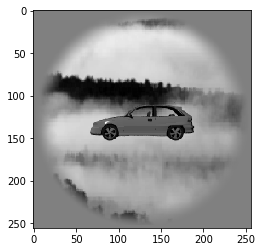

In [11]:
%matplotlib inline
from matplotlib import pyplot, image
img = image.imread(image_path)
pyplot.imshow(img)
pyplot.show()